In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tqdm
import os
import wandb
import torch.nn.functional as F

# Hyperparameters
mb_size = 64
Z_dim = 1000
h_dim = 128
lr = 1e-3
y_dim = 10

# New Section

In [2]:
# Load MNIST data
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Lambda(lambda x: x.view(-1)) # Flatten the 28x28 image to 784
])
train_dataset = datasets.MNIST(root='../MNIST', train=True, transform=transform,
download=True)
train_loader = DataLoader(train_dataset, batch_size=mb_size, shuffle=True)
X_dim = 784 # 28 x 28

100%|██████████| 9.91M/9.91M [00:00<00:00, 42.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.16MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.70MB/s]


In [3]:
# Xavier Initialization
def xavier_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [4]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim, h_dim, x_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, x_dim)
        self.apply(xavier_init)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        out = torch.sigmoid(self.fc2(h))
        return out

In [5]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, x_dim, h_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        self.apply(xavier_init)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = torch.sigmoid(self.fc2(h))
        return out

In [6]:
# Training
def cGANTraining(G, D, loss_fn, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    t = tqdm.tqdm(train_loader)

    for it, (X_real, labels) in enumerate(t):
        # Prepare real data
        X_real = X_real.float().to(device)

        # Sample noise and labels
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        ones_label = torch.ones(X_real.size(0), 1).to(device)
        zeros_label = torch.zeros(X_real.size(0), 1).to(device)

        # ================= Train Discriminator =================
        G_sample = G(z)
        D_real = D(X_real)
        D_fake = D(G_sample.detach())

        D_loss_real = loss_fn(D_real, ones_label)
        D_loss_fake = loss_fn(D_fake, zeros_label)
        D_loss = D_loss_real + D_loss_fake
        D_loss_real_total += D_loss_real.item()
        D_loss_fake_total += D_loss_fake.item()

        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()

        # ================= Train Generator ====================
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss = loss_fn(D_fake, ones_label)
        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()

    # ================= Logging =================
    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })

    return G, D, G_loss_avg, D_loss_avg

In [7]:
def save_sample(G, epoch, mb_size, Z_dim,name):
    out_dir = name
    G.eval()
    with torch.no_grad():
        z = torch.randn(mb_size, Z_dim).to(device)
        samples = G(z).detach().cpu().numpy()[:16]

    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    if not os.path.exists(f'{out_dir}'):
        os.makedirs(f'{out_dir}')

    plt.savefig(f'{out_dir}/{str(epoch).zfill(3)}.png', bbox_inches='tight')
    plt.close(fig)

In [8]:
########################### Main #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function
def my_bce_loss(preds, targets):
    return F.binary_cross_entropy(preds, targets)

#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = my_bce_loss

if wandb_log:
    wandb.init(project="lab2")  # 👈 Add mode="disabled"

    # Log hyperparameters
    wandb.config.update({
        "batch_size": mb_size,
        "Z_dim": Z_dim,
        "X_dim": X_dim,
        "h_dim": h_dim,
        "lr": lr,
    })


best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints'
os.makedirs(save_dir, exist_ok=True)

#Train epochs
epochs = 100

for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg= cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch{epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim,"out_vanila_GAN2")




cuda:0


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: antfol-1 (ertveh-4-lule-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 938/938 [00:11<00:00, 82.68it/s]


epoch0; D_loss: 0.0611; G_loss: 6.2353
Saved Best Models at epoch 0 | G_loss: 6.2353


100%|██████████| 938/938 [00:10<00:00, 87.69it/s]


epoch1; D_loss: 0.0201; G_loss: 7.1225


100%|██████████| 938/938 [00:10<00:00, 88.24it/s]


epoch2; D_loss: 0.0324; G_loss: 6.1664
Saved Best Models at epoch 2 | G_loss: 6.1664


100%|██████████| 938/938 [00:10<00:00, 88.67it/s]


epoch3; D_loss: 0.0367; G_loss: 6.9058


100%|██████████| 938/938 [00:10<00:00, 88.32it/s]


epoch4; D_loss: 0.0941; G_loss: 6.0441
Saved Best Models at epoch 4 | G_loss: 6.0441


100%|██████████| 938/938 [00:10<00:00, 88.26it/s]


epoch5; D_loss: 0.1999; G_loss: 5.1965
Saved Best Models at epoch 5 | G_loss: 5.1965


100%|██████████| 938/938 [00:10<00:00, 88.34it/s]


epoch6; D_loss: 0.2755; G_loss: 4.3661
Saved Best Models at epoch 6 | G_loss: 4.3661


100%|██████████| 938/938 [00:10<00:00, 88.62it/s]


epoch7; D_loss: 0.3301; G_loss: 3.8666
Saved Best Models at epoch 7 | G_loss: 3.8666


100%|██████████| 938/938 [00:10<00:00, 89.13it/s]


epoch8; D_loss: 0.3903; G_loss: 3.4736
Saved Best Models at epoch 8 | G_loss: 3.4736


100%|██████████| 938/938 [00:10<00:00, 89.20it/s]


epoch9; D_loss: 0.4723; G_loss: 3.1973
Saved Best Models at epoch 9 | G_loss: 3.1973


100%|██████████| 938/938 [00:10<00:00, 89.26it/s]


epoch10; D_loss: 0.5012; G_loss: 3.0780
Saved Best Models at epoch 10 | G_loss: 3.0780


100%|██████████| 938/938 [00:10<00:00, 89.39it/s]


epoch11; D_loss: 0.5386; G_loss: 2.9009
Saved Best Models at epoch 11 | G_loss: 2.9009


100%|██████████| 938/938 [00:10<00:00, 89.11it/s]


epoch12; D_loss: 0.5828; G_loss: 2.6844
Saved Best Models at epoch 12 | G_loss: 2.6844


100%|██████████| 938/938 [00:10<00:00, 87.77it/s]


epoch13; D_loss: 0.6033; G_loss: 2.6007
Saved Best Models at epoch 13 | G_loss: 2.6007


100%|██████████| 938/938 [00:10<00:00, 88.54it/s]


epoch14; D_loss: 0.6331; G_loss: 2.5030
Saved Best Models at epoch 14 | G_loss: 2.5030


100%|██████████| 938/938 [00:10<00:00, 88.50it/s]


epoch15; D_loss: 0.6389; G_loss: 2.5274


100%|██████████| 938/938 [00:10<00:00, 87.53it/s]


epoch16; D_loss: 0.6742; G_loss: 2.4292
Saved Best Models at epoch 16 | G_loss: 2.4292


100%|██████████| 938/938 [00:10<00:00, 87.69it/s]


epoch17; D_loss: 0.6682; G_loss: 2.3798
Saved Best Models at epoch 17 | G_loss: 2.3798


100%|██████████| 938/938 [00:10<00:00, 89.14it/s]


epoch18; D_loss: 0.6739; G_loss: 2.3760
Saved Best Models at epoch 18 | G_loss: 2.3760


100%|██████████| 938/938 [00:10<00:00, 88.49it/s]


epoch19; D_loss: 0.6754; G_loss: 2.3636
Saved Best Models at epoch 19 | G_loss: 2.3636


100%|██████████| 938/938 [00:10<00:00, 88.42it/s]


epoch20; D_loss: 0.6712; G_loss: 2.3696


100%|██████████| 938/938 [00:10<00:00, 88.99it/s]


epoch21; D_loss: 0.6759; G_loss: 2.3212
Saved Best Models at epoch 21 | G_loss: 2.3212


100%|██████████| 938/938 [00:10<00:00, 89.42it/s]


epoch22; D_loss: 0.6706; G_loss: 2.3656


100%|██████████| 938/938 [00:10<00:00, 89.05it/s]


epoch23; D_loss: 0.6619; G_loss: 2.3666


100%|██████████| 938/938 [00:10<00:00, 88.96it/s]


epoch24; D_loss: 0.6699; G_loss: 2.3836


100%|██████████| 938/938 [00:10<00:00, 89.26it/s]


epoch25; D_loss: 0.6614; G_loss: 2.3918


100%|██████████| 938/938 [00:10<00:00, 88.43it/s]


epoch26; D_loss: 0.6576; G_loss: 2.4591


100%|██████████| 938/938 [00:10<00:00, 89.05it/s]


epoch27; D_loss: 0.6577; G_loss: 2.4763


100%|██████████| 938/938 [00:10<00:00, 88.41it/s]


epoch28; D_loss: 0.6441; G_loss: 2.4899


100%|██████████| 938/938 [00:10<00:00, 88.21it/s]


epoch29; D_loss: 0.6455; G_loss: 2.5192


100%|██████████| 938/938 [00:10<00:00, 88.68it/s]


epoch30; D_loss: 0.6422; G_loss: 2.5337


100%|██████████| 938/938 [00:10<00:00, 89.25it/s]


epoch31; D_loss: 0.6444; G_loss: 2.5508


100%|██████████| 938/938 [00:10<00:00, 89.23it/s]


epoch32; D_loss: 0.6378; G_loss: 2.5685


100%|██████████| 938/938 [00:10<00:00, 89.43it/s]


epoch33; D_loss: 0.6334; G_loss: 2.5922


100%|██████████| 938/938 [00:10<00:00, 88.31it/s]


epoch34; D_loss: 0.6186; G_loss: 2.6022


100%|██████████| 938/938 [00:10<00:00, 89.22it/s]


epoch35; D_loss: 0.6076; G_loss: 2.6318


100%|██████████| 938/938 [00:10<00:00, 88.48it/s]


epoch36; D_loss: 0.6070; G_loss: 2.6404


100%|██████████| 938/938 [00:10<00:00, 89.38it/s]


epoch37; D_loss: 0.6045; G_loss: 2.6624


100%|██████████| 938/938 [00:10<00:00, 88.51it/s]


epoch38; D_loss: 0.5987; G_loss: 2.7032


100%|██████████| 938/938 [00:10<00:00, 88.80it/s]


epoch39; D_loss: 0.5908; G_loss: 2.7458


100%|██████████| 938/938 [00:10<00:00, 88.44it/s]


epoch40; D_loss: 0.5885; G_loss: 2.7644


100%|██████████| 938/938 [00:10<00:00, 88.69it/s]


epoch41; D_loss: 0.5762; G_loss: 2.7856


100%|██████████| 938/938 [00:10<00:00, 88.99it/s]


epoch42; D_loss: 0.5779; G_loss: 2.7970


100%|██████████| 938/938 [00:10<00:00, 89.01it/s]


epoch43; D_loss: 0.5695; G_loss: 2.8366


100%|██████████| 938/938 [00:10<00:00, 88.94it/s]


epoch44; D_loss: 0.5668; G_loss: 2.8911


100%|██████████| 938/938 [00:10<00:00, 88.92it/s]


epoch45; D_loss: 0.5604; G_loss: 2.8882


100%|██████████| 938/938 [00:10<00:00, 88.95it/s]


epoch46; D_loss: 0.5572; G_loss: 2.8980


100%|██████████| 938/938 [00:10<00:00, 89.38it/s]


epoch47; D_loss: 0.5572; G_loss: 2.9023


100%|██████████| 938/938 [00:10<00:00, 89.14it/s]


epoch48; D_loss: 0.5522; G_loss: 2.9167


100%|██████████| 938/938 [00:10<00:00, 88.34it/s]


epoch49; D_loss: 0.5480; G_loss: 2.9253


100%|██████████| 938/938 [00:10<00:00, 88.27it/s]


epoch50; D_loss: 0.5448; G_loss: 2.9071


100%|██████████| 938/938 [00:10<00:00, 88.66it/s]


epoch51; D_loss: 0.5385; G_loss: 2.8809


100%|██████████| 938/938 [00:10<00:00, 88.00it/s]


epoch52; D_loss: 0.5382; G_loss: 2.9265


100%|██████████| 938/938 [00:10<00:00, 88.41it/s]


epoch53; D_loss: 0.5298; G_loss: 2.9131


100%|██████████| 938/938 [00:10<00:00, 88.57it/s]


epoch54; D_loss: 0.5256; G_loss: 2.9324


100%|██████████| 938/938 [00:10<00:00, 88.76it/s]


epoch55; D_loss: 0.5272; G_loss: 2.9423


100%|██████████| 938/938 [00:10<00:00, 88.41it/s]


epoch56; D_loss: 0.5120; G_loss: 2.9351


100%|██████████| 938/938 [00:10<00:00, 88.73it/s]


epoch57; D_loss: 0.5143; G_loss: 2.9264


100%|██████████| 938/938 [00:10<00:00, 88.49it/s]


epoch58; D_loss: 0.5082; G_loss: 2.9287


100%|██████████| 938/938 [00:10<00:00, 88.20it/s]


epoch59; D_loss: 0.5104; G_loss: 2.9760


100%|██████████| 938/938 [00:10<00:00, 88.60it/s]


epoch60; D_loss: 0.5037; G_loss: 2.9904


100%|██████████| 938/938 [00:10<00:00, 89.61it/s]


epoch61; D_loss: 0.4966; G_loss: 2.9574


100%|██████████| 938/938 [00:10<00:00, 88.92it/s]


epoch62; D_loss: 0.4962; G_loss: 3.0058


100%|██████████| 938/938 [00:10<00:00, 89.03it/s]


epoch63; D_loss: 0.4892; G_loss: 2.9740


100%|██████████| 938/938 [00:10<00:00, 87.90it/s]


epoch64; D_loss: 0.4892; G_loss: 2.9764


100%|██████████| 938/938 [00:10<00:00, 88.50it/s]


epoch65; D_loss: 0.4811; G_loss: 2.9859


100%|██████████| 938/938 [00:10<00:00, 89.02it/s]


epoch66; D_loss: 0.4811; G_loss: 3.0257


100%|██████████| 938/938 [00:10<00:00, 89.19it/s]


epoch67; D_loss: 0.4742; G_loss: 3.0709


100%|██████████| 938/938 [00:10<00:00, 89.12it/s]


epoch68; D_loss: 0.4730; G_loss: 3.0500


100%|██████████| 938/938 [00:10<00:00, 88.78it/s]


epoch69; D_loss: 0.4622; G_loss: 3.0702


100%|██████████| 938/938 [00:10<00:00, 88.56it/s]


epoch70; D_loss: 0.4650; G_loss: 3.0937


100%|██████████| 938/938 [00:10<00:00, 88.41it/s]


epoch71; D_loss: 0.4574; G_loss: 3.1146


100%|██████████| 938/938 [00:10<00:00, 89.21it/s]


epoch72; D_loss: 0.4513; G_loss: 3.1053


100%|██████████| 938/938 [00:10<00:00, 88.47it/s]


epoch73; D_loss: 0.4480; G_loss: 3.1220


100%|██████████| 938/938 [00:10<00:00, 88.96it/s]


epoch74; D_loss: 0.4481; G_loss: 3.1656


100%|██████████| 938/938 [00:10<00:00, 88.34it/s]


epoch75; D_loss: 0.4445; G_loss: 3.1675


100%|██████████| 938/938 [00:10<00:00, 88.37it/s]


epoch76; D_loss: 0.4413; G_loss: 3.1894


100%|██████████| 938/938 [00:10<00:00, 89.14it/s]


epoch77; D_loss: 0.4354; G_loss: 3.1924


100%|██████████| 938/938 [00:10<00:00, 88.43it/s]


epoch78; D_loss: 0.4312; G_loss: 3.2187


100%|██████████| 938/938 [00:10<00:00, 88.68it/s]


epoch79; D_loss: 0.4287; G_loss: 3.2443


100%|██████████| 938/938 [00:10<00:00, 89.21it/s]


epoch80; D_loss: 0.4286; G_loss: 3.2511


100%|██████████| 938/938 [00:10<00:00, 88.92it/s]


epoch81; D_loss: 0.4229; G_loss: 3.2826


100%|██████████| 938/938 [00:10<00:00, 89.13it/s]


epoch82; D_loss: 0.4213; G_loss: 3.2810


100%|██████████| 938/938 [00:10<00:00, 88.49it/s]


epoch83; D_loss: 0.4137; G_loss: 3.3273


100%|██████████| 938/938 [00:10<00:00, 88.16it/s]


epoch84; D_loss: 0.4162; G_loss: 3.3339


100%|██████████| 938/938 [00:10<00:00, 89.30it/s]


epoch85; D_loss: 0.4135; G_loss: 3.3734


100%|██████████| 938/938 [00:10<00:00, 89.18it/s]


epoch86; D_loss: 0.4127; G_loss: 3.3583


100%|██████████| 938/938 [00:10<00:00, 88.46it/s]


epoch87; D_loss: 0.4080; G_loss: 3.3922


100%|██████████| 938/938 [00:10<00:00, 86.98it/s]


epoch88; D_loss: 0.4059; G_loss: 3.3890


100%|██████████| 938/938 [00:10<00:00, 89.64it/s]


epoch89; D_loss: 0.4014; G_loss: 3.4081


100%|██████████| 938/938 [00:10<00:00, 88.31it/s]


epoch90; D_loss: 0.3977; G_loss: 3.4346


100%|██████████| 938/938 [00:10<00:00, 88.87it/s]


epoch91; D_loss: 0.3993; G_loss: 3.4472


100%|██████████| 938/938 [00:10<00:00, 87.53it/s]


epoch92; D_loss: 0.3924; G_loss: 3.4550


100%|██████████| 938/938 [00:10<00:00, 87.40it/s]


epoch93; D_loss: 0.3909; G_loss: 3.4597


100%|██████████| 938/938 [00:10<00:00, 88.19it/s]


epoch94; D_loss: 0.3919; G_loss: 3.4927


100%|██████████| 938/938 [00:10<00:00, 88.41it/s]


epoch95; D_loss: 0.3913; G_loss: 3.4911


100%|██████████| 938/938 [00:10<00:00, 88.80it/s]


epoch96; D_loss: 0.3828; G_loss: 3.4965


100%|██████████| 938/938 [00:10<00:00, 88.93it/s]


epoch97; D_loss: 0.3830; G_loss: 3.5367


100%|██████████| 938/938 [00:10<00:00, 89.54it/s]


epoch98; D_loss: 0.3808; G_loss: 3.5178


100%|██████████| 938/938 [00:10<00:00, 88.92it/s]


epoch99; D_loss: 0.3811; G_loss: 3.5513


In [9]:
# Inference
G.load_state_dict(torch.load('checkpoints/G_best.pth'))
G.eval()

save_sample(G, "best", mb_size, Z_dim, "out_vanila_GAN2")

**Task 2**

In [10]:
def cGANTraining_log(G, D, D_solver, G_solver, loss_d, loss_g, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    t = tqdm.tqdm(train_loader)

    for it, (X_real, labels) in enumerate(t):
        # Prepare real data
        X_real = X_real.float().to(device)

        # Generate a random mask (1 = known pixel, 0 = missing pixel)
        mask = (torch.rand_like(X_real) > 0.5).float().to(device)

        # Create masked input
        X_input = X_real * mask

        # ================= Train Discriminator =================
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        G_sample = G(z)

        D_real = D(X_real)
        D_fake = D(G_sample.detach())  # Detach to avoid backprop through G

        D_loss = loss_d(D_real, D_fake)

        D_loss_real_total += (-torch.mean(torch.log(D_real + 1e-8))).item()
        D_loss_fake_total += (-torch.mean(torch.log(1 - D_fake + 1e-8))).item()

        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()

        # ================= Train Generator ====================
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        G_sample = G(z)
        D_fake = D(G_sample)

        # *** CHANGED: pass real, generated, and mask to loss_g ***
        G_loss = loss_g(G_sample, X_real, mask, D_fake)

        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()

    # ================= Logging =================
    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })

    return G, D, G_loss_avg, D_loss_avg


In [11]:
########################### Main #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Instantiate models
G = Generator(Z_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, h_dim).to(device)

# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)


# Contextual Loss (L1 on known pixels)
def contextual_loss(x_generated, x_original, mask):
    diff = torch.abs(x_generated - x_original)  # absolute difference
    masked_diff = diff * mask  # only focus on known pixels
    return masked_diff.sum() / (mask.sum() + 1e-8)  # mean over valid pixels

# Perceptual Loss (standard GAN fooling loss)
def perceptual_loss(D_fake):
    return F.binary_cross_entropy(D_fake, torch.ones_like(D_fake))

# Generator total loss
def generator_total_loss(x_generated, x_original, mask, D_fake, lambda_contextual=0.1):
    c_loss = contextual_loss(x_generated, x_original, mask)
    p_loss = perceptual_loss(D_fake)
    return lambda_contextual * c_loss + (1.0 - lambda_contextual) * p_loss

# Discriminator loss (standard GAN loss)
def discriminator_loss(D_real, D_fake):
    real_loss = F.binary_cross_entropy(D_real, torch.ones_like(D_real))
    fake_loss = F.binary_cross_entropy(D_fake, torch.zeros_like(D_fake))
    return (real_loss + fake_loss) / 2


loss_d = discriminator_loss  # new
loss_g = generator_total_loss  # new


if wandb_log:
    wandb.init(project="lab2")  # 👈 Add mode="disabled"

    # Log hyperparameters
    wandb.config.update({
        "batch_size": mb_size,
        "Z_dim": Z_dim,
        "X_dim": X_dim,
        "h_dim": h_dim,
        "lr": lr,
    })


best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints_logistic'
os.makedirs(save_dir, exist_ok=True)

#Train epochs
epochs = 100

for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg= cGANTraining_log(G, D,D_solver,G_solver ,loss_d,loss_g, train_loader)

    print(f'epoch{epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best_logistic.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best_logistic.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim,"out_vanila_GAN2_logistic")




cuda:0


D_loss,▁▁▆▇█████████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅
D_loss_fake,▁▁▃▄▆▇▇██████████▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▄
D_loss_real,▁▁▃▇▇███████▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅
G_loss,▇█▅▃▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃
D_loss,0.38111
D_loss_fake,0.16218
D_loss_real,0.21893
G_loss,3.55131


100%|██████████| 938/938 [00:11<00:00, 82.42it/s]


epoch0; D_loss: 0.0601; G_loss: 5.8810
Saved Best Models at epoch 0 | G_loss: 5.8810


100%|██████████| 938/938 [00:11<00:00, 83.95it/s]


epoch1; D_loss: 0.0191; G_loss: 6.1926


100%|██████████| 938/938 [00:11<00:00, 83.63it/s]


epoch2; D_loss: 0.0250; G_loss: 5.4083
Saved Best Models at epoch 2 | G_loss: 5.4083


100%|██████████| 938/938 [00:11<00:00, 83.79it/s]


epoch3; D_loss: 0.0546; G_loss: 5.6266


100%|██████████| 938/938 [00:11<00:00, 83.56it/s]


epoch4; D_loss: 0.1447; G_loss: 4.6708
Saved Best Models at epoch 4 | G_loss: 4.6708


100%|██████████| 938/938 [00:11<00:00, 83.70it/s]


epoch5; D_loss: 0.2349; G_loss: 3.9903
Saved Best Models at epoch 5 | G_loss: 3.9903


100%|██████████| 938/938 [00:11<00:00, 83.79it/s]


epoch6; D_loss: 0.3488; G_loss: 3.6006
Saved Best Models at epoch 6 | G_loss: 3.6006


100%|██████████| 938/938 [00:11<00:00, 84.80it/s]


epoch7; D_loss: 0.4043; G_loss: 3.0775
Saved Best Models at epoch 7 | G_loss: 3.0775


100%|██████████| 938/938 [00:11<00:00, 84.39it/s]


epoch8; D_loss: 0.4863; G_loss: 2.7109
Saved Best Models at epoch 8 | G_loss: 2.7109


100%|██████████| 938/938 [00:11<00:00, 84.68it/s]


epoch9; D_loss: 0.5387; G_loss: 2.6499
Saved Best Models at epoch 9 | G_loss: 2.6499


100%|██████████| 938/938 [00:11<00:00, 84.57it/s]


epoch10; D_loss: 0.5909; G_loss: 2.4702
Saved Best Models at epoch 10 | G_loss: 2.4702


100%|██████████| 938/938 [00:11<00:00, 84.77it/s]


epoch11; D_loss: 0.6258; G_loss: 2.3390
Saved Best Models at epoch 11 | G_loss: 2.3390


100%|██████████| 938/938 [00:11<00:00, 84.23it/s]


epoch12; D_loss: 0.6312; G_loss: 2.1814
Saved Best Models at epoch 12 | G_loss: 2.1814


100%|██████████| 938/938 [00:11<00:00, 84.05it/s]


epoch13; D_loss: 0.6295; G_loss: 2.1229
Saved Best Models at epoch 13 | G_loss: 2.1229


100%|██████████| 938/938 [00:11<00:00, 84.08it/s]


epoch14; D_loss: 0.6336; G_loss: 2.1901


100%|██████████| 938/938 [00:11<00:00, 84.26it/s]


epoch15; D_loss: 0.6437; G_loss: 2.1698


100%|██████████| 938/938 [00:11<00:00, 84.16it/s]


epoch16; D_loss: 0.6480; G_loss: 2.1885


100%|██████████| 938/938 [00:11<00:00, 83.73it/s]


epoch17; D_loss: 0.6585; G_loss: 2.1740


100%|██████████| 938/938 [00:11<00:00, 84.01it/s]


epoch18; D_loss: 0.6577; G_loss: 2.1205
Saved Best Models at epoch 18 | G_loss: 2.1205


100%|██████████| 938/938 [00:11<00:00, 83.83it/s]


epoch19; D_loss: 0.6573; G_loss: 2.1339


100%|██████████| 938/938 [00:11<00:00, 83.94it/s]


epoch20; D_loss: 0.6636; G_loss: 2.1408


100%|██████████| 938/938 [00:11<00:00, 83.82it/s]


epoch21; D_loss: 0.6769; G_loss: 2.1043
Saved Best Models at epoch 21 | G_loss: 2.1043


100%|██████████| 938/938 [00:11<00:00, 83.60it/s]


epoch22; D_loss: 0.6819; G_loss: 2.0865
Saved Best Models at epoch 22 | G_loss: 2.0865


100%|██████████| 938/938 [00:11<00:00, 83.72it/s]


epoch23; D_loss: 0.6771; G_loss: 2.0802
Saved Best Models at epoch 23 | G_loss: 2.0802


100%|██████████| 938/938 [00:11<00:00, 83.70it/s]


epoch24; D_loss: 0.6703; G_loss: 2.1141


100%|██████████| 938/938 [00:11<00:00, 83.79it/s]


epoch25; D_loss: 0.6559; G_loss: 2.1460


100%|██████████| 938/938 [00:11<00:00, 83.43it/s]


epoch26; D_loss: 0.6557; G_loss: 2.1514


100%|██████████| 938/938 [00:11<00:00, 83.41it/s]


epoch27; D_loss: 0.6590; G_loss: 2.1527


100%|██████████| 938/938 [00:11<00:00, 83.89it/s]


epoch28; D_loss: 0.6419; G_loss: 2.1879


100%|██████████| 938/938 [00:11<00:00, 83.24it/s]


epoch29; D_loss: 0.6305; G_loss: 2.2268


100%|██████████| 938/938 [00:11<00:00, 83.60it/s]


epoch30; D_loss: 0.6217; G_loss: 2.2641


100%|██████████| 938/938 [00:11<00:00, 83.52it/s]


epoch31; D_loss: 0.6154; G_loss: 2.3077


100%|██████████| 938/938 [00:11<00:00, 83.07it/s]


epoch32; D_loss: 0.6089; G_loss: 2.3386


100%|██████████| 938/938 [00:11<00:00, 83.96it/s]


epoch33; D_loss: 0.5959; G_loss: 2.3766


100%|██████████| 938/938 [00:11<00:00, 84.33it/s]


epoch34; D_loss: 0.5941; G_loss: 2.4137


100%|██████████| 938/938 [00:11<00:00, 83.40it/s]


epoch35; D_loss: 0.5904; G_loss: 2.4296


100%|██████████| 938/938 [00:11<00:00, 83.40it/s]


epoch36; D_loss: 0.5882; G_loss: 2.4838


100%|██████████| 938/938 [00:11<00:00, 84.36it/s]


epoch37; D_loss: 0.5806; G_loss: 2.4992


100%|██████████| 938/938 [00:11<00:00, 84.07it/s]


epoch38; D_loss: 0.5803; G_loss: 2.5558


100%|██████████| 938/938 [00:11<00:00, 84.34it/s]


epoch39; D_loss: 0.5719; G_loss: 2.5510


100%|██████████| 938/938 [00:11<00:00, 83.74it/s]


epoch40; D_loss: 0.5704; G_loss: 2.5845


100%|██████████| 938/938 [00:11<00:00, 83.99it/s]


epoch41; D_loss: 0.5655; G_loss: 2.5856


100%|██████████| 938/938 [00:11<00:00, 83.43it/s]


epoch42; D_loss: 0.5625; G_loss: 2.6072


100%|██████████| 938/938 [00:11<00:00, 84.01it/s]


epoch43; D_loss: 0.5596; G_loss: 2.6275


100%|██████████| 938/938 [00:11<00:00, 82.60it/s]


epoch44; D_loss: 0.5585; G_loss: 2.6295


100%|██████████| 938/938 [00:11<00:00, 82.88it/s]


epoch45; D_loss: 0.5519; G_loss: 2.6450


100%|██████████| 938/938 [00:11<00:00, 83.96it/s]


epoch46; D_loss: 0.5471; G_loss: 2.6450


100%|██████████| 938/938 [00:11<00:00, 84.40it/s]


epoch47; D_loss: 0.5449; G_loss: 2.6541


100%|██████████| 938/938 [00:11<00:00, 83.52it/s]


epoch48; D_loss: 0.5478; G_loss: 2.6675


100%|██████████| 938/938 [00:11<00:00, 83.86it/s]


epoch49; D_loss: 0.5439; G_loss: 2.6808


100%|██████████| 938/938 [00:11<00:00, 83.77it/s]


epoch50; D_loss: 0.5435; G_loss: 2.6830


100%|██████████| 938/938 [00:11<00:00, 84.34it/s]


epoch51; D_loss: 0.5402; G_loss: 2.6843


100%|██████████| 938/938 [00:11<00:00, 84.21it/s]


epoch52; D_loss: 0.5375; G_loss: 2.6901


100%|██████████| 938/938 [00:11<00:00, 84.17it/s]


epoch53; D_loss: 0.5314; G_loss: 2.6956


100%|██████████| 938/938 [00:11<00:00, 84.00it/s]


epoch54; D_loss: 0.5288; G_loss: 2.6962


100%|██████████| 938/938 [00:11<00:00, 83.60it/s]


epoch55; D_loss: 0.5251; G_loss: 2.7059


100%|██████████| 938/938 [00:11<00:00, 84.20it/s]


epoch56; D_loss: 0.5214; G_loss: 2.7182


100%|██████████| 938/938 [00:11<00:00, 84.39it/s]


epoch57; D_loss: 0.5196; G_loss: 2.7193


100%|██████████| 938/938 [00:11<00:00, 83.95it/s]


epoch58; D_loss: 0.5155; G_loss: 2.7275


100%|██████████| 938/938 [00:11<00:00, 84.21it/s]


epoch59; D_loss: 0.5095; G_loss: 2.7215


100%|██████████| 938/938 [00:11<00:00, 83.66it/s]


epoch60; D_loss: 0.5050; G_loss: 2.7433


100%|██████████| 938/938 [00:11<00:00, 83.89it/s]


epoch61; D_loss: 0.4991; G_loss: 2.7376


100%|██████████| 938/938 [00:11<00:00, 83.49it/s]


epoch62; D_loss: 0.4960; G_loss: 2.7654


100%|██████████| 938/938 [00:11<00:00, 83.53it/s]


epoch63; D_loss: 0.4894; G_loss: 2.7893


100%|██████████| 938/938 [00:11<00:00, 84.06it/s]


epoch64; D_loss: 0.4890; G_loss: 2.7817


100%|██████████| 938/938 [00:11<00:00, 84.25it/s]


epoch65; D_loss: 0.4868; G_loss: 2.7942


100%|██████████| 938/938 [00:11<00:00, 83.29it/s]


epoch66; D_loss: 0.4841; G_loss: 2.7899


100%|██████████| 938/938 [00:11<00:00, 83.66it/s]


epoch67; D_loss: 0.4796; G_loss: 2.8057


100%|██████████| 938/938 [00:11<00:00, 83.64it/s]


epoch68; D_loss: 0.4750; G_loss: 2.8248


100%|██████████| 938/938 [00:11<00:00, 83.67it/s]


epoch69; D_loss: 0.4728; G_loss: 2.8389


100%|██████████| 938/938 [00:11<00:00, 83.70it/s]


epoch70; D_loss: 0.4670; G_loss: 2.8475


100%|██████████| 938/938 [00:11<00:00, 83.83it/s]


epoch71; D_loss: 0.4656; G_loss: 2.8834


100%|██████████| 938/938 [00:11<00:00, 83.22it/s]


epoch72; D_loss: 0.4607; G_loss: 2.8503


100%|██████████| 938/938 [00:11<00:00, 84.15it/s]


epoch73; D_loss: 0.4609; G_loss: 2.8798


100%|██████████| 938/938 [00:11<00:00, 84.41it/s]


epoch74; D_loss: 0.4546; G_loss: 2.8927


100%|██████████| 938/938 [00:11<00:00, 83.84it/s]


epoch75; D_loss: 0.4518; G_loss: 2.9185


100%|██████████| 938/938 [00:11<00:00, 83.80it/s]


epoch76; D_loss: 0.4509; G_loss: 2.9060


100%|██████████| 938/938 [00:11<00:00, 83.15it/s]


epoch77; D_loss: 0.4458; G_loss: 2.9199


100%|██████████| 938/938 [00:11<00:00, 84.06it/s]


epoch78; D_loss: 0.4459; G_loss: 2.9317


100%|██████████| 938/938 [00:11<00:00, 83.83it/s]


epoch79; D_loss: 0.4422; G_loss: 2.9382


100%|██████████| 938/938 [00:11<00:00, 83.71it/s]


epoch80; D_loss: 0.4390; G_loss: 2.9711


100%|██████████| 938/938 [00:11<00:00, 83.83it/s]


epoch81; D_loss: 0.4359; G_loss: 2.9422


100%|██████████| 938/938 [00:11<00:00, 83.28it/s]


epoch82; D_loss: 0.4341; G_loss: 2.9832


100%|██████████| 938/938 [00:11<00:00, 83.71it/s]


epoch83; D_loss: 0.4376; G_loss: 2.9782


100%|██████████| 938/938 [00:11<00:00, 83.32it/s]


epoch84; D_loss: 0.4321; G_loss: 2.9953


100%|██████████| 938/938 [00:11<00:00, 83.71it/s]


epoch85; D_loss: 0.4272; G_loss: 2.9984


100%|██████████| 938/938 [00:11<00:00, 83.43it/s]


epoch86; D_loss: 0.4251; G_loss: 2.9928


100%|██████████| 938/938 [00:11<00:00, 83.67it/s]


epoch87; D_loss: 0.4190; G_loss: 3.0092


100%|██████████| 938/938 [00:11<00:00, 83.88it/s]


epoch88; D_loss: 0.4184; G_loss: 3.0206


100%|██████████| 938/938 [00:11<00:00, 84.38it/s]


epoch89; D_loss: 0.4183; G_loss: 3.0278


100%|██████████| 938/938 [00:11<00:00, 83.73it/s]


epoch90; D_loss: 0.4142; G_loss: 3.0460


100%|██████████| 938/938 [00:11<00:00, 83.55it/s]


epoch91; D_loss: 0.4146; G_loss: 3.0392


100%|██████████| 938/938 [00:11<00:00, 83.35it/s]


epoch92; D_loss: 0.4066; G_loss: 3.0358


100%|██████████| 938/938 [00:11<00:00, 83.93it/s]


epoch93; D_loss: 0.4100; G_loss: 3.0816


100%|██████████| 938/938 [00:11<00:00, 83.53it/s]


epoch94; D_loss: 0.4042; G_loss: 3.0597


100%|██████████| 938/938 [00:11<00:00, 82.82it/s]


epoch95; D_loss: 0.4037; G_loss: 3.0958


100%|██████████| 938/938 [00:11<00:00, 83.42it/s]


epoch96; D_loss: 0.4046; G_loss: 3.1248


100%|██████████| 938/938 [00:11<00:00, 83.76it/s]


epoch97; D_loss: 0.4021; G_loss: 3.1085


100%|██████████| 938/938 [00:11<00:00, 83.82it/s]


epoch98; D_loss: 0.3963; G_loss: 3.1094


100%|██████████| 938/938 [00:11<00:00, 84.05it/s]


epoch99; D_loss: 0.3952; G_loss: 3.1256


In [12]:
# Inference
G.load_state_dict(torch.load('checkpoints_logistic/G_best_logistic.pth'))
G.eval()

save_sample(G, "best", mb_size, Z_dim, "out_vanila_GAN2_logistic")

**Task 3**


In [13]:
class Generator(nn.Module):
    def __init__(self, z_dim, label_dim, h_dim, x_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim + label_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, x_dim)
        self.apply(xavier_init)

    def forward(self, z, labels):
        # Concatenate noise and label
        input = torch.cat([z, labels], dim=1)
        h = F.relu(self.fc1(input))
        out = torch.sigmoid(self.fc2(h))
        return out


In [14]:
class Discriminator(nn.Module):
    def __init__(self, x_dim, label_dim, h_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(x_dim + label_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 1)
        self.apply(xavier_init)

    def forward(self, x, labels):
        input = torch.cat([x, labels], dim=1)
        h = F.relu(self.fc1(input))
        out = torch.sigmoid(self.fc2(h))
        return out


In [15]:
def one_hot(labels, num_classes=10):
    return F.one_hot(labels, num_classes).float()


In [16]:
def save_sample(G, epoch, mb_size, Z_dim, label):
    out_dir = "out_cgan_samples"
    G.eval()
    with torch.no_grad():
        z = torch.randn(mb_size, Z_dim).to(device)
        labels = torch.full((mb_size,), label, dtype=torch.long, device=device)
        labels_onehot = one_hot(labels, num_classes=10).to(device)
        samples = G(z, labels_onehot).detach().cpu().numpy()[:16]  # take 16 samples

    # Create output directory if it doesn't exist
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    # Plotting
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    # Save the image
    plt.savefig(f'{out_dir}/{str(epoch).zfill(3)}_label_{label}.png', bbox_inches='tight')
    plt.close(fig)



In [17]:
def cGANTraining(G, D, loss_fn, train_loader):
    G.train()
    D.train()

    D_loss_real_total = 0
    D_loss_fake_total = 0
    G_loss_total = 0
    t = tqdm.tqdm(train_loader)

    ones_label = torch.ones(mb_size, 1).to(device)
    zeros_label = torch.zeros(mb_size, 1).to(device)

    for it, (X_real, labels) in enumerate(t):
        X_real = X_real.float().to(device)
        labels = labels.to(device)
        labels_onehot = one_hot(labels, num_classes=10).to(device)

        # Sample noise and random fake labels
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        rand_labels = torch.randint(0, 10, (X_real.size(0),), device=device)
        # Use num_classes=10 for consistency
        rand_labels_onehot = one_hot(rand_labels, num_classes=10).to(device)

        # ================ Train Discriminator ================
        G_sample = G(z, rand_labels_onehot)
        D_real = D(X_real, labels_onehot)
        D_fake = D(G_sample.detach(), rand_labels_onehot)

        D_loss_real = loss_fn(D_real, ones_label[:X_real.size(0)])
        D_loss_fake = loss_fn(D_fake, zeros_label[:X_real.size(0)])
        D_loss = D_loss_real + D_loss_fake
        D_loss_real_total += D_loss_real.item()
        D_loss_fake_total += D_loss_fake.item()

        D_solver.zero_grad()
        D_loss.backward()
        D_solver.step()

        # ================ Train Generator ===================
        z = torch.randn(X_real.size(0), Z_dim).to(device)
        rand_labels = torch.randint(0, 10, (X_real.size(0),), device=device)
        # Use num_classes=10 for consistency
        rand_labels_onehot = one_hot(rand_labels, num_classes=10).to(device)

        G_sample = G(z, rand_labels_onehot)
        D_fake = D(G_sample, rand_labels_onehot)

        G_loss = loss_fn(D_fake, ones_label[:X_real.size(0)])
        G_loss_total += G_loss.item()

        G_solver.zero_grad()
        G_loss.backward()
        G_solver.step()

    # ================= Logging =================
    D_loss_real_avg = D_loss_real_total / len(train_loader)
    D_loss_fake_avg = D_loss_fake_total / len(train_loader)
    D_loss_avg = D_loss_real_avg + D_loss_fake_avg
    G_loss_avg = G_loss_total / len(train_loader)

    wandb.log({
        "D_loss_real": D_loss_real_avg,
        "D_loss_fake": D_loss_fake_avg,
        "D_loss": D_loss_avg,
        "G_loss": G_loss_avg
    })

    return G, D, G_loss_avg, D_loss_avg

In [18]:
########################### Main #######################################
wandb_log = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

label_dim = 10  # MNIST digits 0-9

G = Generator(Z_dim, label_dim, h_dim, X_dim).to(device)
D = Discriminator(X_dim, label_dim, h_dim).to(device)


# Optimizers
G_solver = optim.Adam(G.parameters(), lr=lr)
D_solver = optim.Adam(D.parameters(), lr=lr)

# Loss function
def my_bce_loss(preds, targets):
    return F.binary_cross_entropy(preds, targets)

#loss_fn = nn.BCEWithLogitsLoss()
loss_fn = my_bce_loss

if wandb_log:
    wandb.init(project="lab2")  # 👈 Add mode="disabled"

    # Log hyperparameters
    wandb.config.update({
        "batch_size": mb_size,
        "Z_dim": Z_dim,
        "X_dim": X_dim,
        "h_dim": h_dim,
        "lr": lr,
    })


best_g_loss = float('inf')  # Initialize best generator loss
save_dir = 'checkpoints_gen_num'
os.makedirs(save_dir, exist_ok=True)

#Train epochs
epochs = 100

for epoch in range(epochs):
    G, D, G_loss_avg, D_loss_avg= cGANTraining(G, D, loss_fn, train_loader)

    print(f'epoch{epoch}; D_loss: {D_loss_avg:.4f}; G_loss: {G_loss_avg:.4f}')

    if G_loss_avg < best_g_loss:
        best_g_loss = G_loss_avg
        torch.save(G.state_dict(), os.path.join(save_dir, 'G_best.pth'))
        torch.save(D.state_dict(), os.path.join(save_dir, 'D_best.pth'))
        print(f"Saved Best Models at epoch {epoch} | G_loss: {best_g_loss:.4f}")

    save_sample(G, epoch, mb_size, Z_dim, label=3)





cuda:0


D_loss,▁▁▂▃▅▇████████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅
D_loss_fake,▁▁▃▇▇█████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅
D_loss_real,▁▃▆▇▇█████████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅
G_loss,█▇▄▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃
D_loss,0.39523
D_loss_fake,0.16817
D_loss_real,0.22706
G_loss,3.12556


100%|██████████| 938/938 [00:11<00:00, 84.75it/s]


epoch0; D_loss: 0.0676; G_loss: 6.5543
Saved Best Models at epoch 0 | G_loss: 6.5543


100%|██████████| 938/938 [00:11<00:00, 84.56it/s]


epoch1; D_loss: 0.0225; G_loss: 8.0753


100%|██████████| 938/938 [00:11<00:00, 85.07it/s]


epoch2; D_loss: 0.0209; G_loss: 6.4509
Saved Best Models at epoch 2 | G_loss: 6.4509


100%|██████████| 938/938 [00:11<00:00, 84.52it/s]


epoch3; D_loss: 0.0523; G_loss: 6.5572


100%|██████████| 938/938 [00:11<00:00, 84.95it/s]


epoch4; D_loss: 0.0948; G_loss: 6.2921
Saved Best Models at epoch 4 | G_loss: 6.2921


100%|██████████| 938/938 [00:11<00:00, 84.33it/s]


epoch5; D_loss: 0.1777; G_loss: 5.7819
Saved Best Models at epoch 5 | G_loss: 5.7819


100%|██████████| 938/938 [00:11<00:00, 84.40it/s]


epoch6; D_loss: 0.3049; G_loss: 5.3320
Saved Best Models at epoch 6 | G_loss: 5.3320


100%|██████████| 938/938 [00:11<00:00, 85.08it/s]


epoch7; D_loss: 0.3873; G_loss: 4.4505
Saved Best Models at epoch 7 | G_loss: 4.4505


100%|██████████| 938/938 [00:11<00:00, 84.63it/s]


epoch8; D_loss: 0.4915; G_loss: 3.9595
Saved Best Models at epoch 8 | G_loss: 3.9595


100%|██████████| 938/938 [00:10<00:00, 85.58it/s]


epoch9; D_loss: 0.5857; G_loss: 3.7922
Saved Best Models at epoch 9 | G_loss: 3.7922


100%|██████████| 938/938 [00:11<00:00, 84.15it/s]


epoch10; D_loss: 0.6659; G_loss: 3.2565
Saved Best Models at epoch 10 | G_loss: 3.2565


100%|██████████| 938/938 [00:11<00:00, 85.19it/s]


epoch11; D_loss: 0.6779; G_loss: 3.0921
Saved Best Models at epoch 11 | G_loss: 3.0921


100%|██████████| 938/938 [00:11<00:00, 85.17it/s]


epoch12; D_loss: 0.6972; G_loss: 2.8506
Saved Best Models at epoch 12 | G_loss: 2.8506


100%|██████████| 938/938 [00:11<00:00, 84.51it/s]


epoch13; D_loss: 0.7029; G_loss: 2.7292
Saved Best Models at epoch 13 | G_loss: 2.7292


100%|██████████| 938/938 [00:11<00:00, 84.80it/s]


epoch14; D_loss: 0.7364; G_loss: 2.5139
Saved Best Models at epoch 14 | G_loss: 2.5139


100%|██████████| 938/938 [00:11<00:00, 84.73it/s]


epoch15; D_loss: 0.7450; G_loss: 2.4031
Saved Best Models at epoch 15 | G_loss: 2.4031


100%|██████████| 938/938 [00:11<00:00, 84.81it/s]


epoch16; D_loss: 0.7773; G_loss: 2.2652
Saved Best Models at epoch 16 | G_loss: 2.2652


100%|██████████| 938/938 [00:10<00:00, 85.58it/s]


epoch17; D_loss: 0.7733; G_loss: 2.1637
Saved Best Models at epoch 17 | G_loss: 2.1637


100%|██████████| 938/938 [00:10<00:00, 85.47it/s]


epoch18; D_loss: 0.7810; G_loss: 2.1067
Saved Best Models at epoch 18 | G_loss: 2.1067


100%|██████████| 938/938 [00:11<00:00, 84.87it/s]


epoch19; D_loss: 0.7704; G_loss: 2.0719
Saved Best Models at epoch 19 | G_loss: 2.0719


100%|██████████| 938/938 [00:11<00:00, 85.25it/s]


epoch20; D_loss: 0.7677; G_loss: 2.0861


100%|██████████| 938/938 [00:11<00:00, 84.84it/s]


epoch21; D_loss: 0.7709; G_loss: 2.0672
Saved Best Models at epoch 21 | G_loss: 2.0672


100%|██████████| 938/938 [00:11<00:00, 84.42it/s]


epoch22; D_loss: 0.7756; G_loss: 2.0393
Saved Best Models at epoch 22 | G_loss: 2.0393


100%|██████████| 938/938 [00:11<00:00, 84.76it/s]


epoch23; D_loss: 0.7713; G_loss: 2.0600


100%|██████████| 938/938 [00:10<00:00, 85.53it/s]


epoch24; D_loss: 0.7627; G_loss: 2.0655


100%|██████████| 938/938 [00:11<00:00, 84.98it/s]


epoch25; D_loss: 0.7622; G_loss: 2.0761


100%|██████████| 938/938 [00:11<00:00, 84.72it/s]


epoch26; D_loss: 0.7630; G_loss: 2.0784


100%|██████████| 938/938 [00:11<00:00, 84.77it/s]


epoch27; D_loss: 0.7663; G_loss: 2.0722


100%|██████████| 938/938 [00:10<00:00, 85.54it/s]


epoch28; D_loss: 0.7683; G_loss: 2.0664


100%|██████████| 938/938 [00:11<00:00, 85.18it/s]


epoch29; D_loss: 0.7632; G_loss: 2.0515


100%|██████████| 938/938 [00:11<00:00, 84.87it/s]


epoch30; D_loss: 0.7586; G_loss: 2.0649


100%|██████████| 938/938 [00:10<00:00, 85.36it/s]


epoch31; D_loss: 0.7580; G_loss: 2.0890


100%|██████████| 938/938 [00:10<00:00, 85.86it/s]


epoch32; D_loss: 0.7523; G_loss: 2.1042


100%|██████████| 938/938 [00:11<00:00, 84.74it/s]


epoch33; D_loss: 0.7474; G_loss: 2.1328


100%|██████████| 938/938 [00:11<00:00, 84.45it/s]


epoch34; D_loss: 0.7451; G_loss: 2.1323


100%|██████████| 938/938 [00:11<00:00, 84.22it/s]


epoch35; D_loss: 0.7415; G_loss: 2.1270


100%|██████████| 938/938 [00:11<00:00, 85.00it/s]


epoch36; D_loss: 0.7431; G_loss: 2.1558


100%|██████████| 938/938 [00:11<00:00, 84.22it/s]


epoch37; D_loss: 0.7405; G_loss: 2.1520


100%|██████████| 938/938 [00:11<00:00, 84.62it/s]


epoch38; D_loss: 0.7363; G_loss: 2.1485


100%|██████████| 938/938 [00:10<00:00, 85.31it/s]


epoch39; D_loss: 0.7372; G_loss: 2.1542


100%|██████████| 938/938 [00:11<00:00, 83.72it/s]


epoch40; D_loss: 0.7264; G_loss: 2.1568


100%|██████████| 938/938 [00:11<00:00, 84.62it/s]


epoch41; D_loss: 0.7313; G_loss: 2.1897


100%|██████████| 938/938 [00:11<00:00, 84.82it/s]


epoch42; D_loss: 0.7238; G_loss: 2.1778


100%|██████████| 938/938 [00:10<00:00, 85.84it/s]


epoch43; D_loss: 0.7246; G_loss: 2.1877


100%|██████████| 938/938 [00:10<00:00, 85.96it/s]


epoch44; D_loss: 0.7241; G_loss: 2.1877


100%|██████████| 938/938 [00:10<00:00, 85.67it/s]


epoch45; D_loss: 0.7227; G_loss: 2.1840


100%|██████████| 938/938 [00:11<00:00, 85.17it/s]


epoch46; D_loss: 0.7198; G_loss: 2.1925


100%|██████████| 938/938 [00:10<00:00, 85.32it/s]


epoch47; D_loss: 0.7172; G_loss: 2.2248


100%|██████████| 938/938 [00:11<00:00, 85.17it/s]


epoch48; D_loss: 0.7213; G_loss: 2.2066


100%|██████████| 938/938 [00:10<00:00, 85.56it/s]


epoch49; D_loss: 0.7137; G_loss: 2.2277


100%|██████████| 938/938 [00:11<00:00, 84.64it/s]


epoch50; D_loss: 0.7177; G_loss: 2.2255


100%|██████████| 938/938 [00:11<00:00, 84.51it/s]


epoch51; D_loss: 0.7107; G_loss: 2.2227


100%|██████████| 938/938 [00:10<00:00, 85.42it/s]


epoch52; D_loss: 0.7111; G_loss: 2.2423


100%|██████████| 938/938 [00:10<00:00, 85.30it/s]


epoch53; D_loss: 0.7123; G_loss: 2.2346


100%|██████████| 938/938 [00:10<00:00, 85.54it/s]


epoch54; D_loss: 0.7128; G_loss: 2.2265


100%|██████████| 938/938 [00:11<00:00, 84.88it/s]


epoch55; D_loss: 0.7142; G_loss: 2.2351


100%|██████████| 938/938 [00:11<00:00, 84.49it/s]


epoch56; D_loss: 0.7125; G_loss: 2.2224


100%|██████████| 938/938 [00:10<00:00, 85.59it/s]


epoch57; D_loss: 0.7104; G_loss: 2.2205


100%|██████████| 938/938 [00:10<00:00, 85.72it/s]


epoch58; D_loss: 0.7080; G_loss: 2.2278


100%|██████████| 938/938 [00:11<00:00, 85.16it/s]


epoch59; D_loss: 0.7095; G_loss: 2.2195


100%|██████████| 938/938 [00:11<00:00, 84.80it/s]


epoch60; D_loss: 0.7065; G_loss: 2.2324


100%|██████████| 938/938 [00:11<00:00, 84.75it/s]


epoch61; D_loss: 0.7055; G_loss: 2.2432


100%|██████████| 938/938 [00:10<00:00, 85.59it/s]


epoch62; D_loss: 0.6991; G_loss: 2.2204


100%|██████████| 938/938 [00:10<00:00, 85.28it/s]


epoch63; D_loss: 0.7008; G_loss: 2.2353


100%|██████████| 938/938 [00:11<00:00, 84.75it/s]


epoch64; D_loss: 0.6959; G_loss: 2.2429


100%|██████████| 938/938 [00:11<00:00, 84.63it/s]


epoch65; D_loss: 0.7019; G_loss: 2.2348


100%|██████████| 938/938 [00:10<00:00, 85.42it/s]


epoch66; D_loss: 0.7020; G_loss: 2.2259


100%|██████████| 938/938 [00:11<00:00, 84.35it/s]


epoch67; D_loss: 0.6984; G_loss: 2.2631


100%|██████████| 938/938 [00:11<00:00, 84.63it/s]


epoch68; D_loss: 0.6987; G_loss: 2.2460


100%|██████████| 938/938 [00:11<00:00, 84.73it/s]


epoch69; D_loss: 0.7031; G_loss: 2.2388


100%|██████████| 938/938 [00:11<00:00, 85.26it/s]


epoch70; D_loss: 0.6969; G_loss: 2.2329


100%|██████████| 938/938 [00:11<00:00, 85.22it/s]


epoch71; D_loss: 0.7007; G_loss: 2.2403


100%|██████████| 938/938 [00:10<00:00, 85.62it/s]


epoch72; D_loss: 0.6980; G_loss: 2.2182


100%|██████████| 938/938 [00:10<00:00, 85.75it/s]


epoch73; D_loss: 0.6954; G_loss: 2.2297


100%|██████████| 938/938 [00:10<00:00, 85.76it/s]


epoch74; D_loss: 0.6946; G_loss: 2.2433


100%|██████████| 938/938 [00:10<00:00, 85.56it/s]


epoch75; D_loss: 0.6928; G_loss: 2.2088


100%|██████████| 938/938 [00:11<00:00, 85.11it/s]


epoch76; D_loss: 0.6915; G_loss: 2.2114


100%|██████████| 938/938 [00:11<00:00, 84.81it/s]


epoch77; D_loss: 0.6944; G_loss: 2.2175


100%|██████████| 938/938 [00:11<00:00, 84.94it/s]


epoch78; D_loss: 0.6894; G_loss: 2.2065


100%|██████████| 938/938 [00:10<00:00, 85.60it/s]


epoch79; D_loss: 0.6891; G_loss: 2.2038


100%|██████████| 938/938 [00:11<00:00, 84.02it/s]


epoch80; D_loss: 0.6868; G_loss: 2.2207


100%|██████████| 938/938 [00:11<00:00, 85.00it/s]


epoch81; D_loss: 0.6889; G_loss: 2.2030


100%|██████████| 938/938 [00:10<00:00, 85.36it/s]


epoch82; D_loss: 0.6867; G_loss: 2.2109


100%|██████████| 938/938 [00:10<00:00, 85.80it/s]


epoch83; D_loss: 0.6914; G_loss: 2.2267


100%|██████████| 938/938 [00:10<00:00, 85.33it/s]


epoch84; D_loss: 0.6909; G_loss: 2.1831


100%|██████████| 938/938 [00:10<00:00, 85.56it/s]


epoch85; D_loss: 0.6839; G_loss: 2.1981


100%|██████████| 938/938 [00:10<00:00, 85.81it/s]


epoch86; D_loss: 0.6887; G_loss: 2.1918


100%|██████████| 938/938 [00:10<00:00, 85.69it/s]


epoch87; D_loss: 0.6836; G_loss: 2.1969


100%|██████████| 938/938 [00:11<00:00, 85.19it/s]


epoch88; D_loss: 0.6838; G_loss: 2.2054


100%|██████████| 938/938 [00:11<00:00, 84.94it/s]


epoch89; D_loss: 0.6861; G_loss: 2.1931


100%|██████████| 938/938 [00:11<00:00, 85.17it/s]


epoch90; D_loss: 0.6822; G_loss: 2.2001


100%|██████████| 938/938 [00:10<00:00, 85.96it/s]


epoch91; D_loss: 0.6782; G_loss: 2.1713


100%|██████████| 938/938 [00:11<00:00, 84.97it/s]


epoch92; D_loss: 0.6817; G_loss: 2.1978


100%|██████████| 938/938 [00:11<00:00, 84.98it/s]


epoch93; D_loss: 0.6828; G_loss: 2.1930


100%|██████████| 938/938 [00:11<00:00, 84.10it/s]


epoch94; D_loss: 0.6811; G_loss: 2.1781


100%|██████████| 938/938 [00:11<00:00, 84.39it/s]


epoch95; D_loss: 0.6758; G_loss: 2.1845


100%|██████████| 938/938 [00:11<00:00, 85.19it/s]


epoch96; D_loss: 0.6761; G_loss: 2.1909


100%|██████████| 938/938 [00:10<00:00, 85.76it/s]


epoch97; D_loss: 0.6769; G_loss: 2.1783


100%|██████████| 938/938 [00:11<00:00, 85.12it/s]


epoch98; D_loss: 0.6759; G_loss: 2.1829


100%|██████████| 938/938 [00:11<00:00, 84.54it/s]


epoch99; D_loss: 0.6794; G_loss: 2.1778


***TEST***


In [19]:
# Inference
G.load_state_dict(torch.load('checkpoints_gen_num/G_best.pth'))
G.eval()

save_sample(G, "test8", mb_size, Z_dim, label=8)

save_sample(G, "test5", mb_size, Z_dim, label=5)

**Task 4**

100%|██████████| 9.91M/9.91M [00:00<00:00, 39.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.52MB/s]


Epoch 1/5, Loss: 0.2134
Epoch 2/5, Loss: 0.0545
Epoch 3/5, Loss: 0.0413
Epoch 4/5, Loss: 0.0312
Epoch 5/5, Loss: 0.0259
Test Accuracy: 0.9893


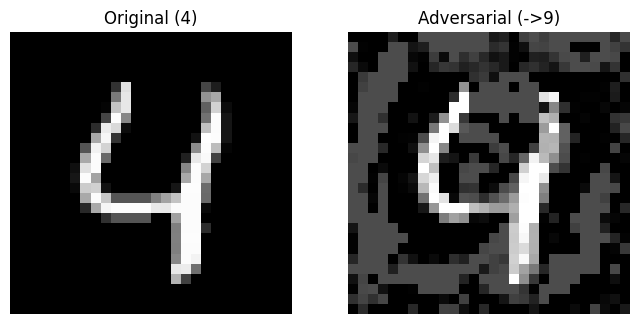

Predicted label for adversarial image: 9


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True

# Hyperparameters
batch_size = 64
epochs = 5
learning_rate = 0.001

# Attack parameters
epsilon = 0.3    # Maximum perturbation
alpha = 0.01     # Step size
num_iterations = 100  # Iterations

# MNIST dataset and DataLoader
transform = transforms.Compose([transforms.ToTensor()])
pin_memory = (device.type == 'cuda')

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          pin_memory=pin_memory, num_workers=4)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         pin_memory=pin_memory, num_workers=4)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*3*3, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Initialize model, loss, optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
model.train()
for epoch in range(1, epochs+1):
    total_loss = 0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()*imgs.size(0)
    print(f"Epoch {epoch}/{epochs}, Loss: {total_loss/len(train_loader.dataset):.4f}")

# Evaluate
model.eval()
with torch.no_grad():
    correct = 0
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        preds = model(imgs).argmax(1)
        correct += (preds==lbls).sum().item()
    print(f"Test Accuracy: {correct/len(test_loader.dataset):.4f}")




# Select one '4'
all_imgs = test_dataset.data.unsqueeze(1).float()/255.0
targets = test_dataset.targets
idx = (targets==4).nonzero()[0].item()
sample = all_imgs[idx:idx+1].to(device)

# Initialize adversarial example with random noise within epsilon-ball

# torch.rand_like(sample) creates uniform noise ∈ [0,1].

# *2*epsilon - epsilon rescales it to ∈ [–ε, +ε].

# Adding this to your clean sample gives adv_img⁽⁰⁾, a random point in the L∞–ball around the original.

# .clamp(0,1) ensures valid pixel range.

# .detach().requires_grad_(True) breaks ties to the original graph and tells PyTorch to track gradients on adv_img.

adv_img = sample + (torch.rand_like(sample)*2*epsilon - epsilon)
adv_img = adv_img.clamp(0,1).detach().requires_grad_(True)



# Targeted PGD: minimize loss for target label 9
target_label = torch.tensor([9], device=device)
# Compute gradient

# outputs = model(adv_img) runs a forward pass on the current perturbed image.

# loss = criterion(outputs, target_label) computes cross‐entropy w.r.t. your target class (9).

# loss.backward() populates adv_img.grad with ∇ₓℓ(model(x), target).
for i in range(num_iterations):
    outputs = model(adv_img)
    loss = criterion(outputs, target_label)
    model.zero_grad()
    loss.backward()
    # Gradient descent step to minimize loss toward target
    # Gradient update

    # You do a small step down the gradient of the target loss (i.e. gradient descent) because you want to minimize ℓ(f(x_adv), 9).

    # alpha * sign(grad) is exactly the FGSM‐style step, but you repeat it T times.
    adv_img = adv_img - alpha * adv_img.grad.sign()
    # Projection: keep within epsilon-ball of original
    #     Projection

    # torch.min(adv_img, sample + ε) caps any pixel that went above original + ε;

    # torch.max(..., sample - ε) caps pixels that went below original - ε.

    # Now ‖adv_img − sample‖∞ ≤ ε is guaranteed.

    # .clamp(0,1) again for legitimate image range.

    # .detach().requires_grad_(True) resets the computational graph so the next backward() computes gradients only w.r.t. the new adv_img.
    adv_img = torch.max(torch.min(adv_img, sample+epsilon), sample-epsilon)
    adv_img = adv_img.clamp(0,1).detach().requires_grad_(True)

# Plot results
orig = sample.squeeze().cpu().numpy()
adversarial = adv_img.detach().squeeze().cpu().numpy()
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(orig, cmap='gray'); plt.title('Original (4)'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(adversarial, cmap='gray'); plt.title('Adversarial (->9)'); plt.axis('off')
plt.show()

# Prediction on adversarial image
with torch.no_grad():
    pred = model(adv_img).argmax(1).item()
print(f"Predicted label for adversarial image: {pred}")

# Every loop iteration thus:

# Measures how far adv_img is from looking like class 9 (via loss).

# Moves it a bit in the direction that reduces that loss (so the network becomes more confident in “9”).

# Projects back so you never stray beyond your allowed perturbation (the ε-ball) or valid pixel range.


**Task 5**